In [120]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy as sp
import scipy.sparse
from scipy.sparse.linalg import inv

# Question 1 Part 1

In [36]:
#Import edge list and clean up data
G = nx.read_edgelist("/Users/jacobeverly/Documents/Graph Science/HW8/hospital_edge.txt", create_using = nx.Graph)
G = nx.convert_node_labels_to_integers(G)

#Established parameters
gamma = 0.1
beta = [0.2,0.5,0.9]

#N number of nodes and edges
NumN = len(G.nodes)
NumE = len(G.edges)

#Make list of degrees and nodes
D = [(G.degree(n)) for n in G.nodes] 
nodes = list(G.nodes)

In [73]:
#Probablity function
def probs(gamma, beta, step, ts, n):
    
    FinDiff1 = (beta/D[n])*(1-ts[step-1][n])
    FinDiff2 = np.sum([ts[step-1][i] for i in nx.neighbors(G,n)])
    
    return FinDiff1 * FinDiff2-gamma * ts[step - 1][n]

In [76]:
#Fit when looking at the graphs converged
ts = 100
#Function for SIR model
def SIR (gamma,beta,NumN,ts):
    ts_arr = np.zeros((ts,NumN))
    rand_infected = random.choice(range(NumN))
    ts_arr[0][rand_infected] = 1
    for j in range(1,ts):
         for i in range(NumN):
            ts_arr[j][i] = probs(gamma, beta, j, ts_arr, i) + ts_arr[j-1][i]
    SIRresults = np.transpose(ts_arr)
    return SIRresults


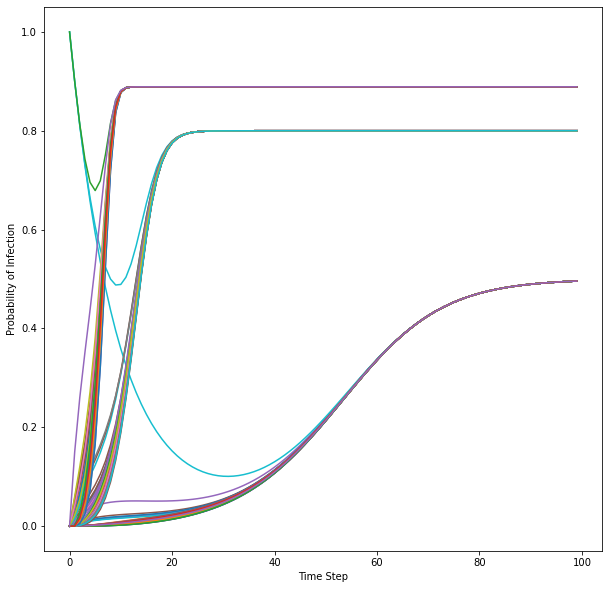

In [77]:
plt.figure(figsize=(10, 10))
for plot in SIR(gamma,beta[0],NumN,ts):
    plt.plot(range(ts), plot)
for plot in SIR(gamma,beta[1],NumN,ts):
    plt.plot(range(ts), plot)
for plot in SIR(gamma,beta[2],NumN,ts):
    plt.plot(range(ts), plot)
plt.xlabel('Time Step')
plt.ylabel('Probability of Infection')
plt.show()

# Question 1 Part 2

In [103]:
#fit graph to the converging time
ts = 100

def SI(beta, NumN):
    ts = 100
    ts_arr = np.zeros((ts,NumN))
    Ninf = np.zeros(ts)
    ts_arr[0][0] = 1
    
    for j in range(1,ts):
        for i in range(NumN):
            if random.uniform(0,1) < beta:
                n = random.choice([n for n in nx.neighbors(G,i)])
                ts_arr[j][i] = (1-ts_arr[j-1][i]) * ts_arr[j-1][n] + ts_arr[j-1][i]
                                                                            
            else:
                ts_arr[j][i] = ts_arr[j-1][i]
                                                                            
        Ninf[j] = np.sum(ts_arr[j])
        TranRate= np.transpose(ts_arr)
                                                                            
    return TranRate , Ninf


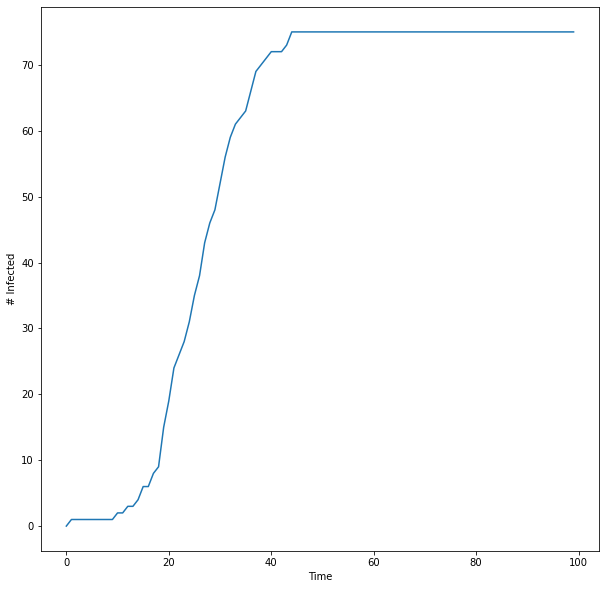

In [105]:
x, Ninf = SI(beta[0],NumN)
plt.figure(figsize=(10, 10))
plt.plot(range(ts), Ninf )
plt.xlabel('Time')
plt.ylabel('# Infected')
plt.show()

Text(0, 0.5, '#')

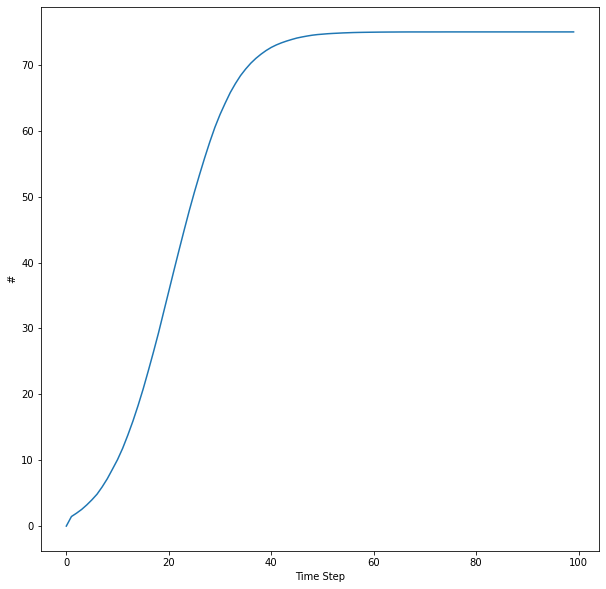

In [112]:
test = np.zeros((1000,ts))
for t in range(1000):
    x, Ninfect = SI(beta[0], NumN)
    test[t] = Ninfect
infected = np.transpose(test)
arr = []
for k in range(ts):
    arr.append(np.mean(infected[k]))
plt.figure(figsize=(10, 10))
plt.plot(range(ts), arr)
plt.xlabel('Time Step')
plt.ylabel('#')

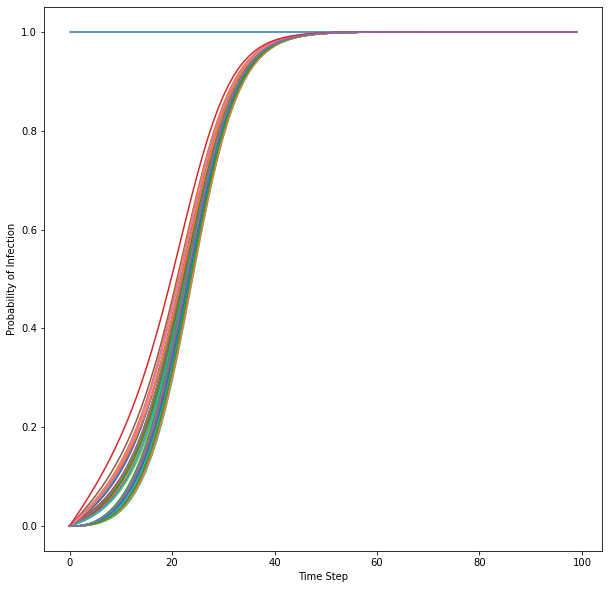

In [116]:
Result = SIR(0, beta[0],NumN, ts)
plt.figure(figsize=(10, 10))
for i in Result:
    plt.plot(range(ts), i)
plt.xlabel('Time Step')
plt.ylabel('Probability of Infection')
plt.show()

# Question 2

In [127]:
G2 = nx.read_edgelist("/Users/jacobeverly/Documents/Graph Science/HW8/rt.txt", create_using = nx.Graph)
NumN2 = len(G2.nodes)
G2 = nx.convert_node_labels_to_integers(G2)
D2 = [(G2.degree(n)) for n in G2.nodes]
alpha = 0.5/(max(D2))

#Given Parameters
th = [0.1, 0.5]

In [145]:
def indicate(y, tau):
    if y <= tau:
        x = 1
    else: x = 0
        
    return x

In [141]:
nodelist = list(G2)
weight="weight"
A = nx.to_scipy_sparse_array(G2, nodelist=nodelist, weight=weight, format="csr")
n, m = A.shape
Diag = sp.sparse.csr_array(sp.sparse.spdiags(A.sum(axis=1), 0, m, n, format="csr"))
laplace = nx.laplacian_matrix(G2)
laplace_rw = inv(Diag).dot(laplace)
mix_mat = (1-alpha) * np.eye(NumN2) - alpha * laplace_rw

<class 'networkx.utils.decorators.argmap'> compilation 13:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/Users/jacobeverly/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/jacobeverly/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [156]:
def HKBC(V, tau, mix_mat, level):
    ts = np.zeros((level,NumN2))
    opinion = np.random.uniform(0,1,NumN)
    ts[0] = opinion
    for h in range(1,level):
        for i in range(NumN2):
            x = np.sum([mix_mat[i,j] * indicate(abs(ts[h-1][i] - ts[h-1][j]), tau) * ts[h-1][j] for j in range(NumN2)])
            y = np.sum([mix_mat[i,j] * indicate(abs(ts[h-1][i] - ts[h-1][j]), tau) for j in range(NumN2)])
            ts[h][i] = x / y
    res = np.transpose(ts)
    return res

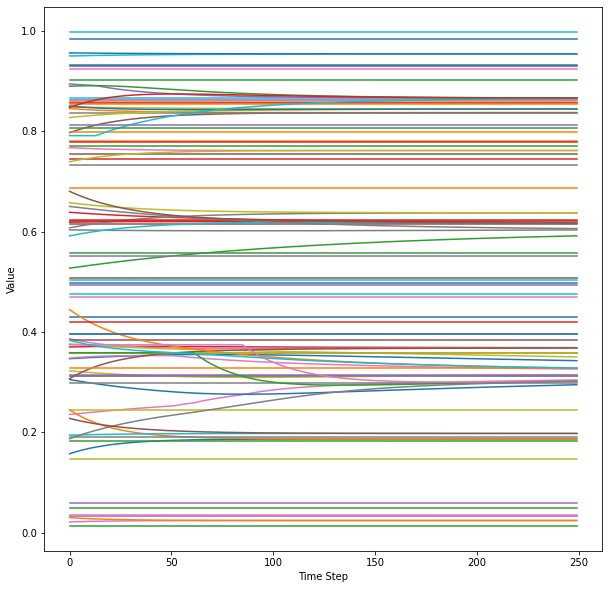

In [158]:
level = 250
plt.figure(figsize=(10, 10))
for i in HKBC(NumN2, 0.1, mix_mat, level):
    plt.plot(range(level), i)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

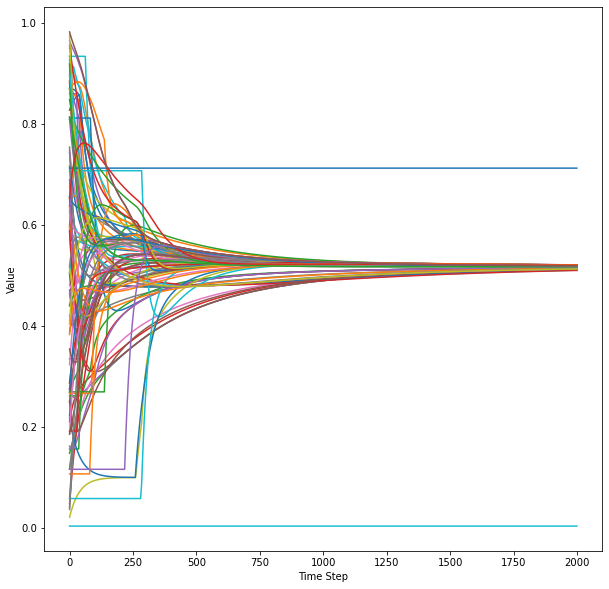

In [161]:
level = 2000
plt.figure(figsize=(10, 10))
for i in HKBC(NumN2, 0.5, mix_mat, level):
    plt.plot(range(level), i)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

# Question 3

In [122]:
import scipy.io
mat = scipy.io.loadmat('/Users/jacobeverly/Documents/Graph Science/HW8/ieee30.mat')
Bbus = mat['Bbus']
Ybus = mat['Ybus']
sinj = mat['sinj']
vp = mat['vp']

In [ ]:
gn = np.linspace(0,29,30)
G3 = nx.random_geometric_graph(30, radius = 0.3, seed = 96845)

In [ ]:
#Part 1, voltage phasers times the conjugate of i, i = admittance*(vp1-vp0)

#Part 2 is the real part of the number, so active - imaginary, to get the angle it should be cos^-1(apparent/active)

#Part 3 


AppPow = []
for i in vp:
    P = (vp[i])*(vp[i])*(Bbus[:,i])
    AppPow.append(P)

    
     

In [162]:
#apparent power
i = Ybus*vp
ap = vp * (np.conjugate(i))

In [163]:
#actual power
ap.real

array([[ 4.15420790e-01],
       [ 3.37018526e-01],
       [-2.40000001e-02],
       [-7.59999999e-02],
       [-1.66044899e-11],
       [ 4.30686742e-10],
       [-2.28000000e-01],
       [-3.00000000e-01],
       [ 1.86270597e-10],
       [-5.79999980e-02],
       [ 0.00000000e+00],
       [-1.12000001e-01],
       [ 1.62002017e-01],
       [-6.19999994e-02],
       [-8.19999972e-02],
       [-3.49999972e-02],
       [-8.99999983e-02],
       [-3.19999989e-02],
       [-9.49999992e-02],
       [-2.19999997e-02],
       [-1.74999999e-01],
       [ 2.27403321e-01],
       [ 1.30669522e-01],
       [-8.69999980e-02],
       [ 1.43344948e-10],
       [-3.50000000e-02],
       [ 3.99090211e-01],
       [ 8.53043942e-10],
       [-2.40000000e-02],
       [-1.06000000e-01]])

In [165]:

I = []
for n in range(len(sinj)):
    I.append(np.sum([Ybus[n,j] * (vp[n]) for j in range(len(sinj))]))
print(I)

[(-2.220446049250313e-16+0.024559314723734182j), (0.0005864991090134275+0.04403840012405613j), (0.00040733705235518336+0.009760690475759226j), (0.00048355513544962037+0.009752376797223405j), (0.0007120800659867754+0.016398953312872777j), (0.0010952506795689487+0.019415717340919514j), (0.0005859603682099035+0.009605189178707008j), (0.0006171995549300036+0.009591358334439803j), 8.881784197001252e-16j, (-1.9984014443252818e-15+4.440892098500626e-15j), 0j, (4.440892098500626e-16+0j), 0j, 8.881784197001252e-16j, (-4.440892098500626e-16+1.7763568394002505e-15j), -1.7763568394002505e-15j, (2.220446049250313e-16-8.881784197001252e-16j), (4.440892098500626e-16+1.7763568394002505e-15j), -1.7763568394002505e-15j, (8.881784197001252e-16-1.7763568394002505e-15j), (-3.552713678800501e-15-7.105427357601002e-15j), (3.552713678800501e-15-6.217248937900877e-15j), (2.220446049250313e-16+4.440892098500626e-16j), (2.7556339879275527e-05+0.00040575300010026183j), (8.881784197001252e-16+0j), 0j, (-1.11022302

In [169]:
bus = Bbus[1:, 1:]
B_inv = inv(bus)
Iarr = I[1:]
thetas = B_inv.dot(Iarr)
thetas

array([0.00021965+0.00579172j, 0.00031934+0.00705791j,
       0.00037028+0.00815336j, 0.00042075+0.00958341j,
       0.00043256+0.00932689j, 0.00045597+0.00989055j,
       0.00046019+0.00977006j, 0.00042671+0.0092055j ,
       0.00042364+0.00914191j, 0.00042671+0.0092055j ,
       0.00040116+0.00872215j, 0.00040116+0.00872215j,
       0.00040523+0.00879631j, 0.00040836+0.00885336j,
       0.00041073+0.00890077j, 0.00041981+0.00907046j,
       0.00041369+0.00895412j, 0.00041685+0.00901367j,
       0.00041854+0.00904573j, 0.00042487+0.00916128j,
       0.00042523+0.00916682j, 0.0004177 +0.00902066j,
       0.00043031+0.00924652j, 0.00044596+0.00953478j,
       0.00044596+0.00953478j, 0.00045592+0.00971822j,
       0.00047488+0.01006763j, 0.00045592+0.00971822j,
       0.00045592+0.00971822j])

In [170]:
from pypower.case30 import case30
ppc = case30()
# \ mathcal { N }
buses = ppc["bus"][:,0] - 1 # -1 because python is 0 - indexed
# \ mathcal { G }
generators = ppc["gen"][:,0] - 1 # -1 because python is 0 - indexed
non_generators = list(set(buses) - set(generators))
demands = ppc["bus"][:,[3]]
g_low = ppc["gen"][:,[9]] # returns only the limits for the generators indexed by the elements in generators .
g_high = ppc["gen"][:,[8]] # returns only the limits for the generators indexed by the elements in generators .

In [172]:
import pypower

from pypower.api import runopf, runpf
print(pypower.api.runopf(ppc))

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.39 seconds
Objective Function Value = 576.89 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0         -95.0 to 405.9
Generators         6     On-line Capacity       335.0         -95.0 to 405.9
Committed Gens     6     Generation (actual)    192.1             105.1
Loads             20     Load                   189.2             107.2
  Fixed           20       Fixed                189.2             107.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         

In [200]:
denseBbus = Bbus.todense()
BbusGen = np.zeros ((6,30) )
BbusNonGen = np.zeros((24,30) )
demandsGen = np.zeros ( (6,1))
demandsNonGen = np.zeros ((24,1))

import cvxpy as cp
gens = cp.Variable(shape=(len (generators),1))
non_gens = cp.Variable(shape=(len(non_generators),1))
theta = cp.Variable(shape=(30,1))
objective = cp.Minimize(cp. sum(gens) + cp. sum (non_gens))
constraints = [
gens >= g_low,
gens <= g_high,
non_gens == 0]
problem = cp.Problem(objective, constraints)
problem.solve (gp=False)
print ( 'Gens:')
(gens.value)
print (('Voltage Phase Angles:'), theta.value)
print ('Objective:', problem. value)

Gens:
Voltage Phase Angles: None
Objective: 1.4141992796711362e-10
